In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

#THEORETICAL FRAMEWORK --------------------------------
#https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023

#DATA SELECTION ----------------------------------
cwd = os.getcwd()
print(cwd)
os.chdir('C://Users//john8/Year 4/Data Analysis')

data= pd.read_csv("spotify-2023.csv", encoding='latin-1')

print(data.info())
print(data.head())
print(data.describe())
print("Number of rows:", data.shape[0])

#IMPUTATION OF MISSING DATA ----------------------------------------

#1. Handling Missing Values:
print("Missing values before handling:")
print(data.isnull().sum())

#track_name               0
#artist(s)_name           0
#artist_count             0
#released_year            0
#released_month           0
#released_day             0
#in_spotify_playlists     0
#in_spotify_charts        0
#streams                  0
#in_apple_playlists       0
#in_apple_charts          0
#in_deezer_playlists      0
#in_deezer_charts         0
#in_shazam_charts        50
#bpm                      0
#key                     95
#mode                     0
#danceability_%           0
#valence_%                0
#energy_%                 0
#acousticness_%           0
#instrumentalness_%       0
#liveness_%               0
#speechiness_%            0                                    

# decide to drop rows where above values are null
data.dropna(subset=['in_shazam_charts', 'key'], inplace=True)
print("\nMissing values after handling:")
print(data.isnull().sum())

# decide to drop rows where values are 0
#data = data[data != 0].dropna()
#data = data[(data != 0).all(axis=1)]

# remove rows with NaN or inf values
#data = data.replace([np.inf, -np.inf], np.nan).dropna()

#2. Outlier Detection and Treatment:

integer_columns = ['artist_count', 'released_year', 'released_month', 'released_day', 
                   'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists',
                   'in_apple_charts', 'in_deezer_charts', 'bpm', 'danceability_%',
                   'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
                   'liveness_%', 'speechiness_%']

# Convert the selected columns to numeric data types
data[integer_columns] = data[integer_columns].apply(pd.to_numeric, errors='coerce')

# Calculate the z-scores for each numeric column
z_scores = np.abs((data[integer_columns] - data[integer_columns].mean()) / data[integer_columns].std())

# Define the threshold for outliers
threshold = 3

# Identify rows where any z-score exceeds the threshold
outliers_mask = (z_scores > threshold).any(axis=1)

# Print the number of rows before dropping outliers
print(f"Number of rows before dropping outliers: {len(data)}")

# Drop rows containing outliers
data.drop(data.index[outliers_mask], inplace=True)

# Print the number of rows dropped
print(f"Number of rows dropped due to outliers: {outliers_mask.sum()}")

# Print the cleaned DataFrame
print(data)

#3. Data Type Conversion:
data_types = data.dtypes
print(data_types)

# Convert 'streams' column to numeric data type
data['streams'] = pd.to_numeric(data['streams'], errors='coerce')

# Convert other object columns to string data type
object_columns = ['track_name', 'artist(s)_name', 'in_deezer_playlists', 'in_shazam_charts', 'key', 'mode']
data[object_columns] = data[object_columns].astype(str)

# Print updated data types
print(data.dtypes)

#4. Handling Duplicates:
duplicate_rows = data[data.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

#5. Feature Engineering:
# decided to make a new column called total playlists by combining in_spotify_playlists, in_apple_playlists and in_deezer_playlists which may be useful later on
# also decided to turn bpm into 3 categories based on number
import numpy as np

# check data types as we came across error when adding +
print("Data Types using info() method:")
print(data[['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']].info())

print("Data Types using dtype attribute:")
print("in_spotify_playlists:", data['in_spotify_playlists'].dtype)
print("in_apple_playlists:", data['in_apple_playlists'].dtype)
print("in_deezer_playlists:", data['in_deezer_playlists'].dtype)

# change 'in_deezer_playlists' column to numeric data type from object to fix iussue
data['in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors='coerce')

# drop if values are 0
data = data[data['in_deezer_playlists'] != 0]
data = data[data['in_apple_playlists'] != 0]
data = data[data['in_spotify_playlists'] != 0]

# verify data types after changing
print("Data Types after Conversion:")
print(data[['in_deezer_playlists']].info())

data['total_playlists'] = data['in_spotify_playlists'] + data['in_apple_playlists'] + data['in_deezer_playlists']

# turn 'bpm' into categories (low, medium, high)
print("Minimum BPM:", data['bpm'].min())
print("Maximum BPM:", data['bpm'].max())

bins = [65, 112, 159, 206]
labels = ['low', 'medium', 'high']

data['bpm_category'] = pd.cut(data['bpm'], bins=bins, labels=labels, right=True)

print(data['bpm_category'])

#6. Encoding Categorical Variables:
# change new bpm categories to numerical value
# Define a dictionary to map labels to numerical values
label_mapping = {'low': 0, 'medium': 1, 'high': 2}

data['bpm_category_encoded'] = data['bpm_category'].map(label_mapping)

data.dropna(subset=['bpm_category_encoded'], inplace=True)

data['bpm_category_encoded'] = data['bpm_category_encoded'].astype(int)


print(data[['bpm_category', 'bpm_category_encoded']].head())

In [ ]:
# Multivariate analysis & Feature Selection ------------------------------------------------
print("Number of rows:", data.shape[0])
print(data.info())
print(data.head())
print(data.describe())

 #   Column                Non-Null Count  Dtype   
#---  ------                --------------  -----   
# 0   track_name            642 non-null    object  
# 1   artist(s)_name        642 non-null    object  
# 2   artist_count          642 non-null    int64   
# 3   released_year         642 non-null    int64   
# 4   released_month        642 non-null    int64   
# 5   released_day          642 non-null    int64   
# 6   in_spotify_playlists  642 non-null    int64   
# 7   in_spotify_charts     642 non-null    int64   
# 8   streams               642 non-null    int64   
# 9   in_apple_playlists    642 non-null    int64   
# 10  in_apple_charts       642 non-null    int64   
# 11  in_deezer_playlists   614 non-null    float64
# 12  in_deezer_charts      642 non-null    int64   
# 13  in_shazam_charts      642 non-null    object  
# 14  bpm                   642 non-null    int64   
# 15  key                   642 non-null    object  
# 16  mode                  642 non-null    object  
# 17  danceability_%        642 non-null    int64   
# 18  valence_%             642 non-null    int64   
# 19  energy_%              642 non-null    int64   
# 20  acousticness_%        642 non-null    int64   
# 21  instrumentalness_%    642 non-null    int64   
# 22  liveness_%            642 non-null    int64   
# 23  speechiness_%         642 non-null    int64   
# 24  total_playlists       614 non-null    float64 
# 25  bpm_category          641 non-null    category
# 26  bpm_category_encoded  641 non-null    int32
# dtypes: category(2), float64(2), int64(18), object(5)

# Correlation Coefficient of DV to IV variables
predictor_variables = ['streams']
response_variables = ['in_spotify_playlists',
                      'in_spotify_charts', 'in_apple_playlists', 
                      'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 
                      'artist_count', 'released_day', 'released_year', 'released_month', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
                       'liveness_%', 'speechiness_%', 'total_playlists']

# change columns to integer type based on values above
data = data.dropna(subset=['in_deezer_playlists'])
data['in_shazam_charts'] = data['in_deezer_playlists'].astype(int)
data['total_playlists'] = data['total_playlists'].astype(int)

for predictor_var in predictor_variables:
    for response_var in response_variables:
        corr_coef, p_value = pearsonr(data[predictor_var], data[response_var])
        print(f"Pearson correlation coefficient between '{predictor_var}' and '{response_var}': {corr_coef:.2f}")

# Scatterplot of DV to IV variables
import matplotlib.pyplot as plt

predictor_var = 'streams'

for response_var in response_variables:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[predictor_var], data[response_var], alpha=0.5, label='Data points')
    plt.title(f"{response_var} vs {predictor_var}")
    plt.xlabel(predictor_var)
    plt.ylabel(response_var)
    
    # fit a linear regression line
    m, b = np.polyfit(data[predictor_var], data[response_var], 1)
    plt.plot(data[predictor_var], m * data[predictor_var] + b, color='red', label='Regression line')
    
    plt.legend()
    plt.show()

# Summary of Correlation Coefficient of DV(streams) to IV variables

#Strong positive correlations (≥ 0.5):
#'in_spotify_playlists': 0.77
#'in_shazam_charts': 0.70
#'in_deezer_playlists': 0.70

#Moderate positive correlations (0.3 ≤ r < 0.5):
#'in_apple_playlists': 0.63
#'total_playlists': 0.78

#Weak positive correlations (0.1 ≤ r < 0.3):
#'released_month': 0.02
#'acousticness_%': 0.01
#'instrumentalness_%': 0.01

#Weak negative correlations (-0.3 ≤ r < -0.1):
#'artist_count': -0.11
#'released_day': 0.06
#'released_year': -0.39
#'danceability_%': -0.10
#'valence_%': -0.10
#'energy_%': -0.07
#'speechiness_%': -0.04

# IV to IV scatterplots and correlations want weak or low correlation
correlation_matrix_all = data[response_variables].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Response Variables")
plt.show()

# Summary of Correlation Coefficient of IV to IV variables
# in_spotify_playlist is highly correlated (0.77) with in_deezer_playlists & in_shazam_charts - top 3 major song platforms ->
# if a song is on a spotify playlist then theres 77% chance its in a deezer playlist OR shazam charts
# opposite is if its either in a deezer playlist OR shazam chart THEN theres 77% chance its in a spotify playlist
# UNEXPECTED 100% of in_deezer_playlists & in_shazam_charts - meaning if a song is in either one then it exists in the other one

# Investigate 100% collinearity of in_deezer_playlists & in_shazam_charts
#1. Check Unique Values: Verify if the values in both columns are identical for all observations. This can help confirm the observed collinearity.

unique_deezer = data['in_deezer_playlists'].unique()
unique_shazam = data['in_shazam_charts'].unique()

print("Unique values in 'in_deezer_playlists':", unique_deezer)
print("Unique values in 'in_shazam_charts':", unique_shazam)

if len(unique_deezer) == 1 and len(unique_shazam) == 1 and unique_deezer[0] == unique_shazam[0]:
    print("The unique values in 'in_deezer_playlists' and 'in_shazam_charts' are identical for all observations.")
else:
    print("The unique values in 'in_deezer_playlists' and 'in_shazam_charts' are not identical for all observations.")


#2. Cross-Tabulation: Create a cross-tabulation (contingency table) between the two variables to see the frequency distribution of their values. This can provide additional insights into the relationship between the variables.
cross_tab = pd.crosstab(data['in_deezer_playlists'], data['in_shazam_charts'])

print("Cross-Tabulation (Contingency Table):")
print(cross_tab)
#In this case, the contingency table reveals that there is a one-to-one correspondence between the values of 'in_deezer_playlists' and 
#'in_shazam_charts'. Each unique value of 'in_deezer_playlists' corresponds to a unique value of 'in_shazam_charts', and vice versa.
#From a data analysis perspective, this indicates a perfect association between the two variables. In other words, whenever a song appears in 
#'in_deezer_playlists', it also appears in 'in_shazam_charts', and vice versa. 
#This could suggest either a strong relationship between these two variables or potential redundancy, as they may convey similar information.

# REVIEW AND CONCLUSION
# drop weak correlation values of DV to IV variables -> released_month, acousticness_%, instrumentalness_%, artist_count, released_day, released_year, danceability_%, valence_%, energy_%, speechiness_%
# drop in_shazam_charts as multi collinearity exists between response variables
# so, although theres 88% collinearity of in_spotify_playlist & in_deezer_playlists - decide to keep in_deezer_playlists as it makes sense and needed for predicting streams

# KEPT VALUES for further analysis and modelling
# predictor - streams
# response - in_spotify_playlists, in_deezer_playlists, in_apple_playlists, total_playlists

In [ ]:
# Normalization & Standardization ----------------------------------

#https://www.digitalocean.com/community/tutorials/normalize-data-in-python
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt

all_response_variables = ['in_spotify_playlists',
                      'in_spotify_charts', 'in_apple_playlists', 
                      'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 
                      'artist_count', 'released_day', 'released_year', 'released_month', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
                       'liveness_%', 'speechiness_%', 'total_playlists']

normalized_variables = ['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists', 'total_playlists', 'streams']

plt.figure(figsize=(10, 6))
data[normalized_variables].boxplot()
plt.title('Box Plot of Response Variables')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

# clear from boxplots that we need to scale and normalize our data, also drop rows where in_spotify_playlist > 15000 as its an outlier
data = data[data['in_spotify_playlists'] < 15000]
data = data[data['in_deezer_playlists'] < 600]

# Normalize the response variables directly in the original DataFrame
data[normalized_variables] = preprocessing.normalize(data[normalized_variables], axis=0)

# Check if data is normalized
magnitudes = np.linalg.norm(data[normalized_variables], axis=0)

# Print the magnitudes after normalization
for var, magnitude in zip(normalized_variables, magnitudes):
    print(f"Magnitude of '{var}' after normalization: {magnitude:.4f}")

# Visualize boxplots of response variables after normalization
plt.figure(figsize=(10, 6))
data[normalized_variables].boxplot()
plt.title('Box Plot of Response Variables (After Normalization)')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

#1. Standardization (Z-score normalization):
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_standardized = scaler.fit_transform(data[normalized_variables])
data_standardized = pd.DataFrame(data_standardized, columns=normalized_variables)
print(data_standardized.head())

#2. Min-Max Scaling:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[normalized_variables] = scaler.fit_transform(data[normalized_variables])
print("Minimum values after Min-Max scaling:")
print(data[normalized_variables].min())
print("\nMaximum values after Min-Max scaling:")
print(data[normalized_variables].max())

#3. Robust Scaling:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
data[normalized_variables] = robust_scaler.fit_transform(data[normalized_variables])
print(data.head())

In [ ]:
# Regression Modelling ----------------------------

  #Conduct simple linear regressions for each IV/DV pair
   # Use the non-redundant independent variables in the analysis to find the best fitting model - use all your different types scaled data for variables to find best model
  # go with one variavle banner then two then three until you find best model
  #best model shows highest r squared mse and ssr
    # Use the best fitting model to make predictions about the dependent variable

# First regression analysis with 'in_spotify_playlists' predicting 'streams'
import statsmodels.api as sm
all_data = sm.add_constant(data['in_spotify_playlists'])
model = sm.OLS(data['streams'], all_data)
result = model.fit()
print(result.summary())
# Line below is for the standard error
print(result.scale**0.5)

# Second regression analysis with both 'in_spotify_playlists', 'in_spotify_charts' & 'in_deezer_playlists' predicting 'streams'
data2 = sm.add_constant(data[['in_spotify_playlists', 'in_deezer_playlists']])
model2 = sm.OLS(data['streams'], data2)
result2 = model2.fit()
print(result2.summary())
# Standard error
print(result2.scale**0.5)
print(result2.ssr)

# Third regression analysis with both 'in_spotify_playlists', 'in_spotify_charts', 'in_deezer_playlists' & 'in_apple_playlists' predicting 'streams'
data3 = sm.add_constant(data[['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists']])
model3 = sm.OLS(data['streams'], data3)
result3 = model3.fit()
print(result3.summary())
# Standard error
print(result3.scale**0.5)
print(result3.ssr)

# Fourth regression analysis with both 'in_spotify_playlists', 'in_spotify_charts', 'in_deezer_playlists', 'in_apple_playlists' & 'total_playlists' predicting 'streams'
data4 = sm.add_constant(data[['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists', 'total_playlists']])
model4 = sm.OLS(data['streams'], data4)
result4 = model4.fit()
print(result4.summary())
# Standard error
print(result4.scale**0.5)
print(result4.ssr)

# Interpretation:
# The model has a moderate-to-high R-squared value of 0.631, indicating that about 63.1% of the variance in the dependent variable (streams) is explained by the independent variables.
# The F-statistic is highly significant (p-value < 0.001), suggesting that the overall regression model is statistically significant.
# The p-values for 'in_spotify_playlists', 'in_deezer_playlists', and 'total_playlists' are all significant (p-value < 0.05), indicating that these variables are likely to have a significant linear relationship with the dependent variable.
# However, 'in_apple_playlists' has a high p-value (p-value = 0.441), indicating that it may not be a significant predictor in the model.
# The AIC and BIC values are 1030 and 1052, respectively, suggesting that this model is relatively better than other models with higher AIC and BIC values.
# The Condition Number (Cond. No.) is very high, indicating potential multicollinearity issues or singularity in the design matrix.

# Conclusion:
# Overall, the model appears to be statistically significant, with most coefficients being significant predictors of the dependent variable. 
# However, the high Condition Number suggests potential multicollinearity issues that should be investigated further. 
# Additionally, the coefficient for 'in_apple_playlists' is not significant, indicating that it may not contribute much to predicting the dependent variable.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

normalized_variables = ['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists', 'total_playlists', 'streams']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[normalized_variables])

pca = PCA()
pca.fit(scaled_data)

# Get the principal components
pca_data = pca.transform(scaled_data)

# Percentage of variance explained by each principal component
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

# Plot scree plot
labels = ['PC' + str(i) for i in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Components")
plt.title('Scree Plot')
plt.show()

# Plot PCA graph
pca_df = pd.DataFrame(pca_data, columns=labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title("PCA graph")
plt.xlabel(f'PC1 {per_var[0]}%')
plt.ylabel(f'PC2 {per_var[1]}%')
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()

# Get loading scores for each variable
loading_scores = pd.Series(pca.components_[0], index=normalized_variables)

# Get top 10 variables contributing most to the principal component
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_variables = sorted_loading_scores[:10]

# Plot top 10 variables
plt.bar(top_10_variables.index, top_10_variables.values)
plt.xlabel('Variable')
plt.ylabel('Loading Score')
plt.title('Top 10 Variables Contributing to First Principal Component')
plt.xticks(rotation=45)
plt.show()

# In conclusion, Principal Component Analysis (PCA) has provided valuable insights into our dataset containing variables related to 
# music streaming platforms. Through standardization and PCA, we transformed our original variables into principal components, 
# which allowed us to identify patterns and reduce the dimensionality of the data. The scree plot helped us understand the variance 
# explained by each principal component, aiding in the decision-making process regarding the number of components to retain. 
# The PCA graph visually depicted the distribution of data points in the reduced-dimensional space, offering a glimpse into potential 
# clusters or patterns. Additionally, analyzing the loading scores helped us identify the variables contributing most significantly to 
# each principal component, providing valuable information about the underlying structure of the data. Overall, PCA has proven to be a 
# powerful tool for exploring and understanding complex datasets, offering a deeper understanding of the relationships and dynamics within the data.


In [ ]:
# Cluster Analysis ------------------------------------

cluster_data = data[['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists', 'total_playlists', 'streams']]

from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Initialize AgglomerativeClustering with parameters
hc = AgglomerativeClustering(n_clusters=4, linkage='complete')

# Fit the clustering model and predict cluster labels
y_hc = hc.fit_predict(cluster_data)

# Visualize the clusters
plt.figure(figsize=(8, 6))

# Scatter plot for each cluster
for i in range(4):
    plt.scatter(cluster_data[y_hc==i, 0], cluster_data[y_hc==i, 1], s=100, label=f'Cluster {i}')

plt.title('Hierarchical Clustering with Complete Linkage')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 1 to 952
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   in_spotify_playlists  601 non-null    float64
 1   in_deezer_playlists   601 non-null    float64
 2   in_apple_playlists    601 non-null    float64
 3   total_playlists       601 non-null    float64
 4   streams               601 non-null    float64
dtypes: float64(5)
memory usage: 28.2 KB


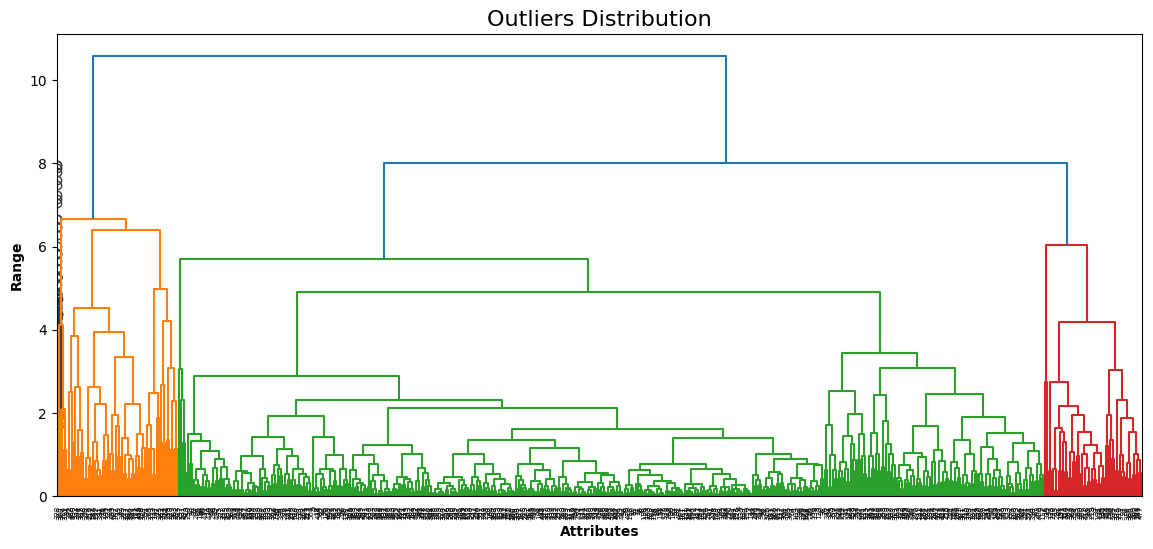

In [46]:
import seaborn as sb
def show_boxplot(df):
    plt.rcParams['figure.figsize'] = [14, 6]
    sb.boxplot(data=df, orient='v')
    plt.title("Outliers Distribution", fontsize=16)
    plt.ylabel("Range", fontweight='bold')
    plt.xlabel("Attributes", fontweight='bold')

cleaned_data = data[['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists', 'total_playlists', 'streams']]
cleaned_data.info()

show_boxplot(cleaned_data)

def remove_outliers(data):
    df = data.copy()
    for col in list(df.columns):
        Q1 = df[str(col)].quantile(0.25)
        Q3 = df[str(col)].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        df = df[(df[str(col)] >= lower_bound) & (df[str(col)] <= upper_bound)]
        return df
    
without_outliers = remove_outliers(cleaned_data)
show_boxplot(without_outliers)
without_outliers.shape

from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(without_outliers)
scaled_data.shape

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

complete_clustering = linkage(scaled_data, method = "complete", metric="euclidean")
average_clustering = linkage(scaled_data, method = "average", metric="euclidean")
single_clustering = linkage(scaled_data, method = "single", metric="euclidean")

dendrogram(complete_clustering)
plt.show()

In [ ]:
# Indexing ---------------------------------

In [ ]:
# Graphs -------------------------------